Notebook purpose

- Document problems in MBD raw data

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
m = aws.S3BucketManager('3di-project-entropy')
m.list()

['3di-project-entropy/entropy_000.parquet',
 '3di-project-entropy/entropy_777.parquet',
 '3di-project-entropy/entropy_X77.parquet']

## Duplicate accounts

In [ ]:
df = aws.s3read_parquet('s3://3di-project-entropy/entropy_X77.parquet')

In [3]:
SAMPLE_SIZE = df.user_id.nunique()

user_sample = pd.Series(df.user_id.unique()).sample(random_state=2312, n=SAMPLE_SIZE)
sample = df[df.user_id.isin(user_sample)]

In [4]:
daily_balances = (sample.set_index('date')
                  .groupby(['account_id', 'account_type', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .sort_values('user_id')
                  .assign(account_label=lambda x: 
                          x.account_type.astype('str') 
                          + '-id' + x.account_id.astype('str')
                          + '-u' + x.user_id.astype('str')))

daily_balances.head(3)

,account_id,account_type,user_id,date,balance,account_label
48079,446213,credit card,17277,2015-04-10,0.01,credit card-id446213-u17277
19262,230283,current,17277,2014-09-07,0.42,current-id230283-u17277
19263,230283,current,17277,2014-09-08,0.42,current-id230283-u17277


### Case studies

In [5]:
user_id = 474377
accounts = [1112517, 1112518]

(daily_balances
 .loc[daily_balances.user_id == user_id]
 .loc[daily_balances.account_id.isin(accounts)]
 .pivot('date', 'account_label', 'balance')).corr()

account_label,savings-id1112517-u474377,savings-id1112518-u474377
account_label,,
savings-id1112517-u474377,1.000000,0.999036
savings-id1112518-u474377,0.999036,1.000000


In [110]:
user_id = 385077
accounts = [742152, 742154]

(daily_balances
 .loc[daily_balances.user_id == user_id]
 .loc[daily_balances.account_id.isin(accounts)]
 .pivot('date', 'account_label', 'balance')).corr()

account_label,savings-742152,savings-742154
account_label,,
savings-742152,1.0,1.0
savings-742154,1.0,1.0


In [108]:
user_id = 512077
accounts = [1292847, 1292848]

(daily_balances
 .loc[daily_balances.user_id == user_id]
 .loc[daily_balances.account_id.isin(accounts)]
 .pivot('date', 'account_label', 'balance')).corr()

account_label,savings-1292847,savings-1292848
account_label,,
savings-1292847,NaN,NaN
savings-1292848,NaN,NaN


No correlation because both series have zero variance.

In [112]:
user_id = 409777
accounts = [1292847, 1292848]

(daily_balances
 .loc[daily_balances.user_id == user_id]
#  .loc[daily_balances.account_id.isin(accounts)]
 .pivot('date', 'account_label', 'balance')).corr()

account_label,current-848287,current-848288,savings-848286,savings-848289
account_label,,,,
current-848287,NaN,NaN,NaN,NaN
current-848288,NaN,NaN,NaN,NaN
savings-848286,NaN,NaN,NaN,NaN
savings-848289,NaN,NaN,NaN,NaN


In [174]:
high_corrs.melt(ignore_index=False, var_name='second_accounts')

,second_accounts,value
account_label,,
credit card-1208695,credit card-1625056,0.999856
credit card-1625056,credit card-1625056,1.000000
credit card-654165,credit card-1625056,NaN
credit card-847163,credit card-1625056,NaN
current-1033768,credit card-1625056,NaN
...,...,...
savings-1340470,savings-894882,NaN
savings-653429,savings-894882,0.972145
savings-742152,savings-894882,-0.771279


### All high correlation accounts

In [8]:
high_corr_pairs = (daily_balances
 .pivot('date', 'account_label', 'balance')
 .corr()
 .where(lambda x: np.triu(np.ones(x.shape), k=1).astype('bool'))
 .melt(var_name='second_account', value_name='correlation', ignore_index=False)
 .reset_index()
 .loc[lambda df: df.correlation > 0.99])

high_corr_pairs.head(3)

,account_label,second_account,correlation
1746,credit card-id1208695-u339577,credit card-id1625056-u339577,0.999856
8957,current-id1033768-u457277,current-id1198578-u457277,1.000000
13259,current-id1442959-u539577,current-id1447001-u539577,1.000000


In [15]:
high_corr_pairs

,account_label,second_account,correlation
1746,credit card-id1208695-u339577,credit card-id1625056-u339577,0.999856
8957,current-id1033768-u457277,current-id1198578-u457277,1.000000
13259,current-id1442959-u539577,current-id1447001-u539577,1.000000
13838,current-id1327946-u518077,current-id1489166-u518077,0.993267
22814,current-id742151-u385077,current-id742153-u385077,0.999633
25934,other-id942614-u436577,other-id947416-u436577,1.000000
27489,savings-id1031594-u456877,savings-id1112517-u474377,0.996737
27689,savings-id1112517-u474377,savings-id1112518-u474377,0.999036
30209,savings-id1107682-u473477,savings-id1327950-u518077,0.995494
30210,savings-id1110037-u473477,savings-id1327950-u518077,0.995443


In [13]:
df.account_id.nunique()

194

In [14]:
df.user_id.nunique()

43

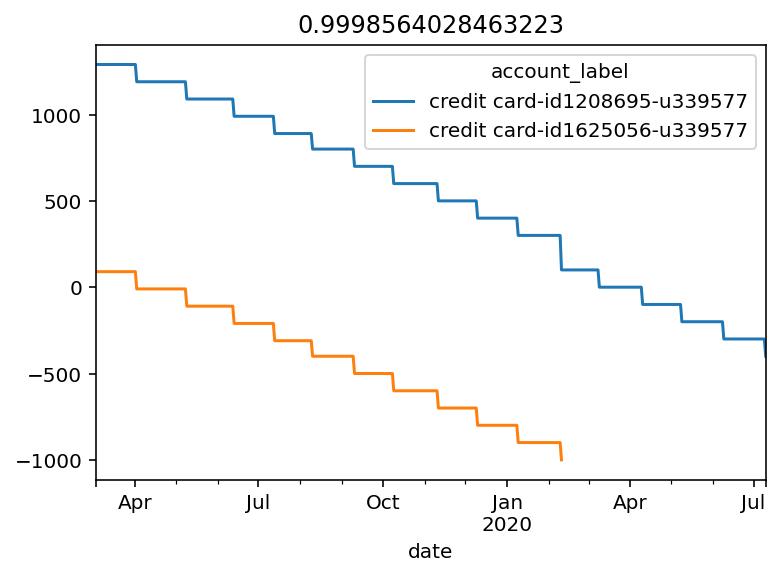

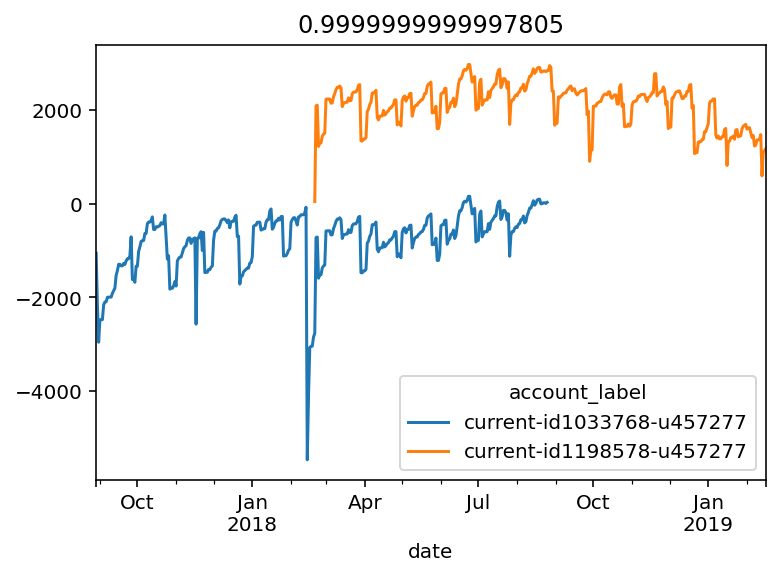

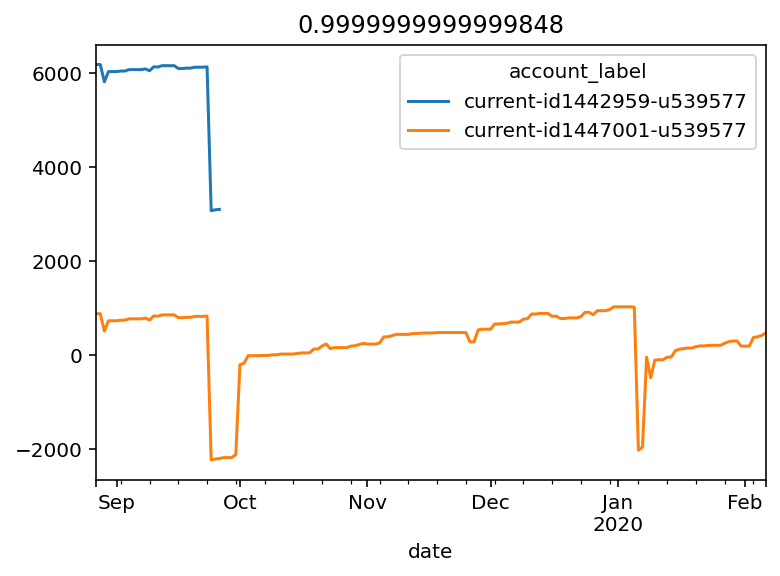

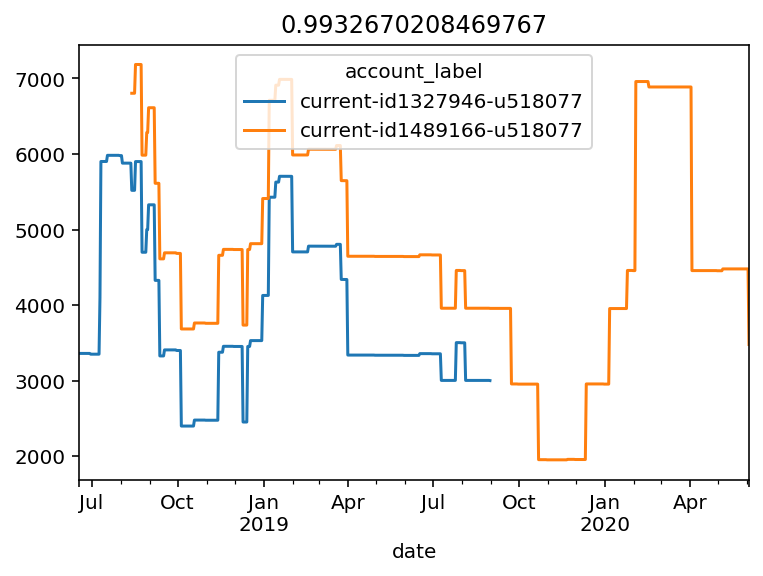

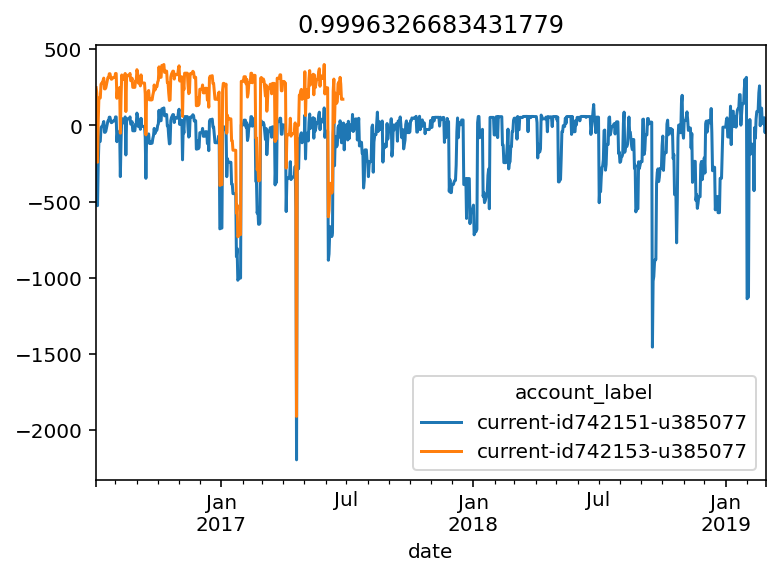

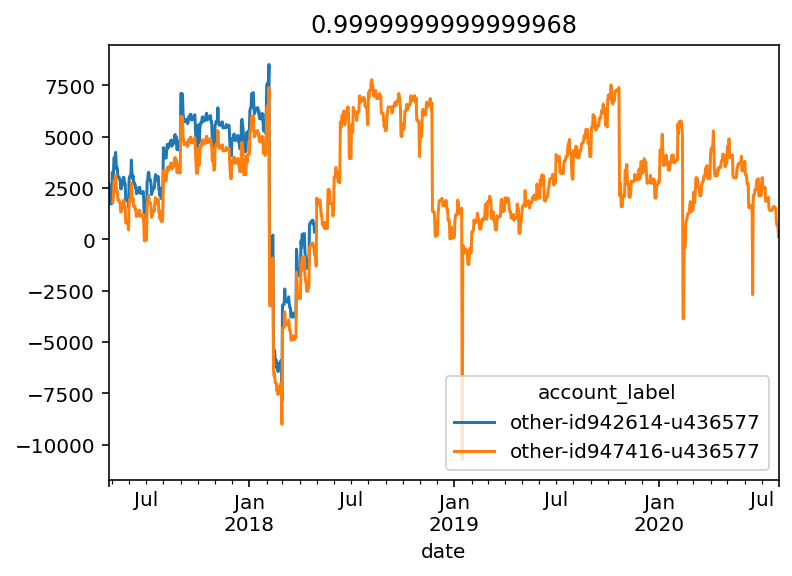

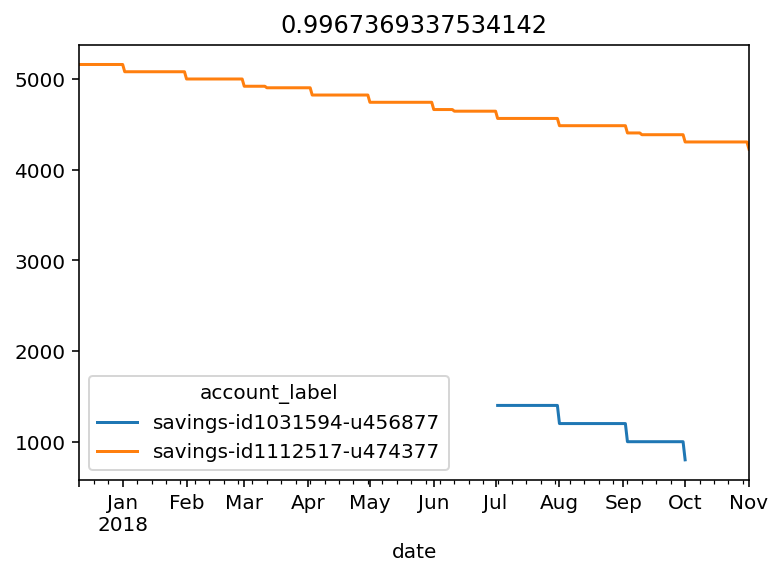

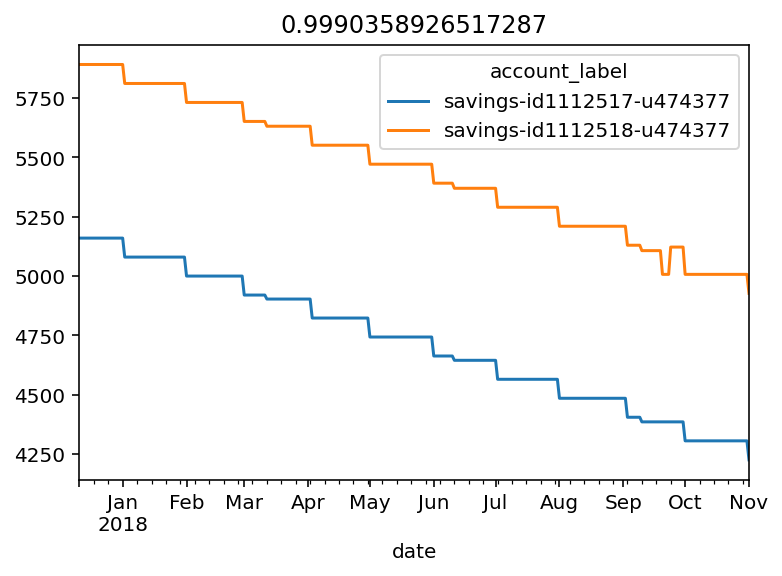

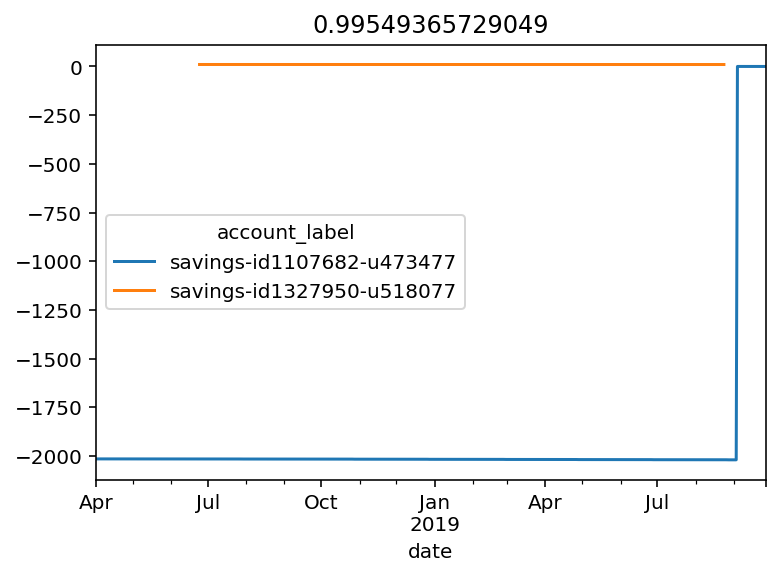

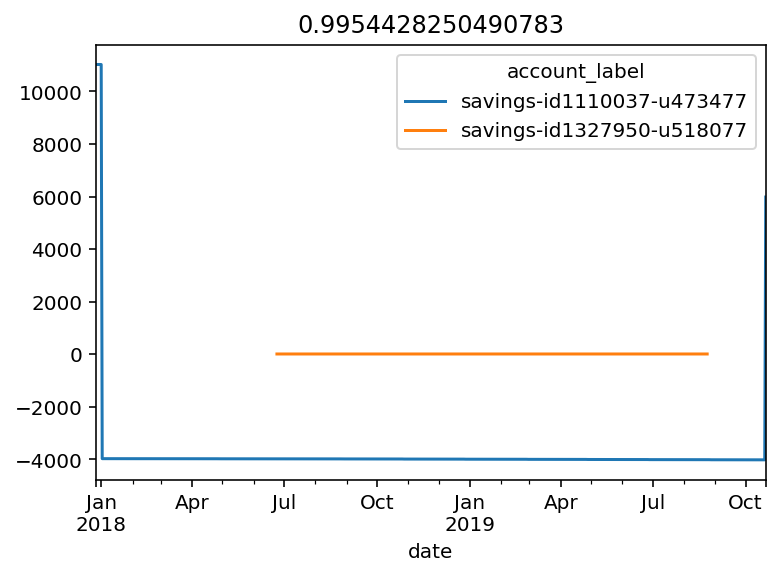

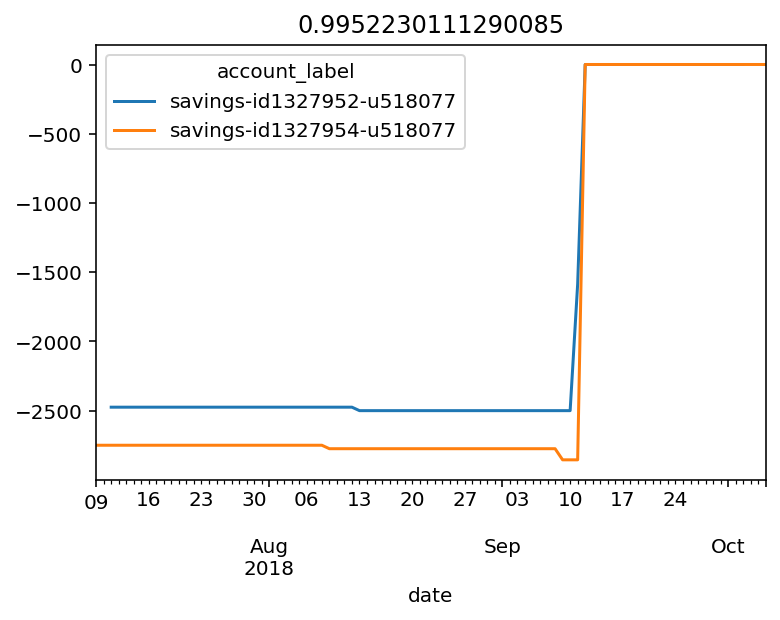

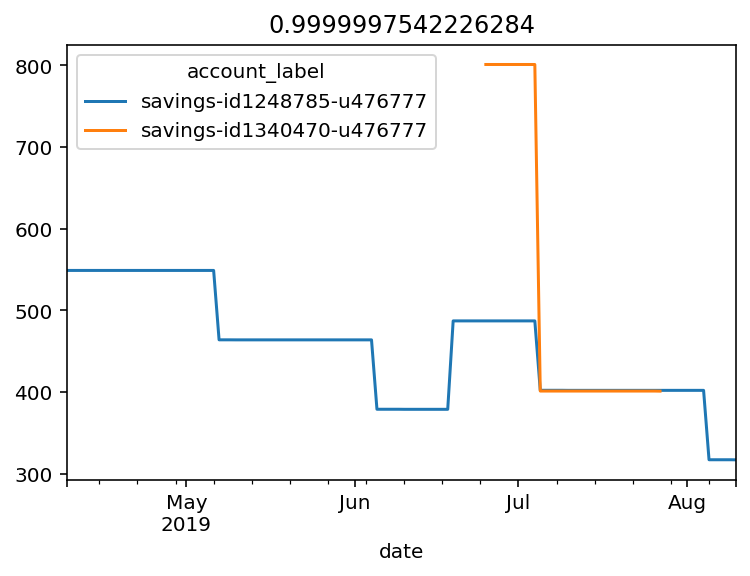

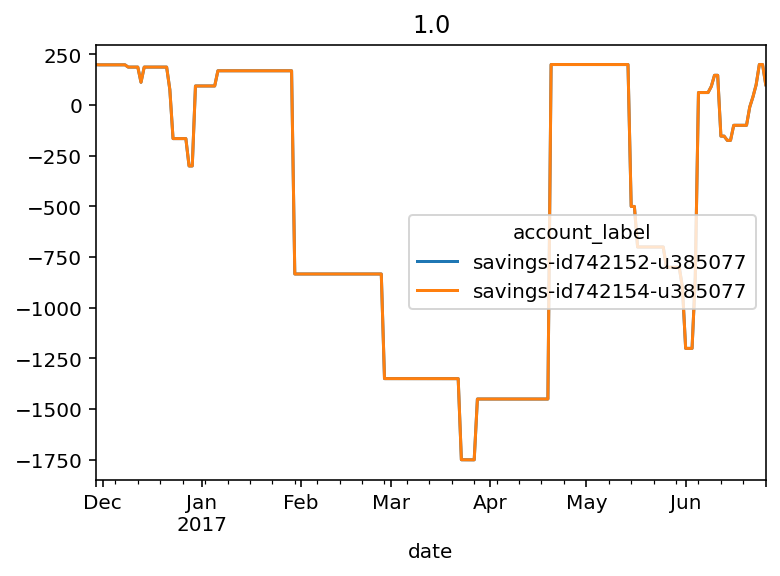

In [286]:
for idx, account1, account2, corr in high_corr_pairs.itertuples():
    data = daily_balances[daily_balances.account_label.isin([account1, account2])]
    data.pivot('date', 'account_label', 'balance').plot(title=corr)